In [1]:
import pandas as pd

In [2]:
data_email = pd.read_csv('data/email_text.csv')

In [3]:
data_email.head()

,label,text
0,1,do you feel the pressure to perform and not ri...
1,0,hi i've just updated from the gulus and i chec...
2,1,mega authenticv i a g r a discount pricec i a ...
3,1,hey billy it was really fun going out the othe...
4,1,system of the home it will have the capabiliti...


In [4]:
data_email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53668 entries, 0 to 53667
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   53668 non-null  int64 
 1   text    53668 non-null  object
dtypes: int64(1), object(1)
memory usage: 838.7+ KB


In [20]:
import re

TAG_RE = re.compile(r'<[^>]+>')
URL_RE = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
TEXT_RE = re.compile(r'(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')

def clean_data(text):
    text = text.lower().strip()
    text = TAG_RE.sub('', text)
    text = URL_RE.sub('', text)
    text = TEXT_RE.sub('', text)
    return text

data_email['text'] = data_email['text'].apply(clean_data)


In [21]:
data_email.head()

,label,text
0,1,do you feel the pressure to perform and not ri...
1,0,hi ive just updated from the gulus and i check...
2,1,mega authenticv i a g r a discount pricec i a ...
3,1,hey billy it was really fun going out the othe...
4,1,system of the home it will have the capabiliti...


In [22]:
dup = data_email.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 46


In [23]:
data_email = data_email.drop_duplicates()

In [24]:
import spacy

nlp = spacy.load("en_core_web_sm")

def remove_stopwords(text):
    doc = nlp(text)
    filtered_text = " ".join([token.text for token in doc if not token.is_stop])
    return filtered_text

data_email['text'] = data_email['text'].apply(remove_stopwords)

In [25]:
data_email.head()

,label,text
0,1,feel pressure perform rising occasion try v ia...
1,0,hi ve updated gulus check mirrors little typo ...
2,1,mega authenticv g r discount pricec l s discou...
3,1,hey billy fun going night talking said felt in...
4,1,system home capabilities linked far know respe...


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt

In [33]:
def search_best_estimator(pipeline, param_grid, x, y):
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
    _ = grid_search.fit(x, y)
    return grid_search.best_params_

In [34]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(16,10))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
    cmp.plot(ax=ax)
    plt.show()

In [35]:
X, y = data_email['text'], data_email['label']

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

param_grid = {
    'tfidf__min_df': [i for i in range(25,35,5)],
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "clf__n_estimators": [i for i in range(150,250,50)],
    "clf__max_depth": [i for i in range(5,35,5)],
    "clf__min_samples_split":[i for i in range(6,10,2)],
    "clf__min_samples_leaf": [2]
}

estimator = search_best_estimator(pipeline, param_grid, X, y)

In [40]:
print(estimator)

{'clf__max_depth': 30, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 6, 'clf__n_estimators': 200, 'tfidf__max_df': 0.9, 'tfidf__min_df': 30, 'tfidf__ngram_range': (1, 1)}


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [41]:
pipeline_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_df = 0.9, min_df=30, ngram_range=(1, 1))),
    ('clf', RandomForestClassifier(max_depth=30, n_estimators=200, min_samples_split=6, min_samples_leaf=2, n_jobs=-1))
])

model = pipeline_model.fit(X_train, y_train)

In [42]:
y_pred = model.predict(X_test)

In [50]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      7124
           1       0.97      1.00      0.98      8963

    accuracy                           0.98     16087
   macro avg       0.98      0.98      0.98     16087
weighted avg       0.98      0.98      0.98     16087



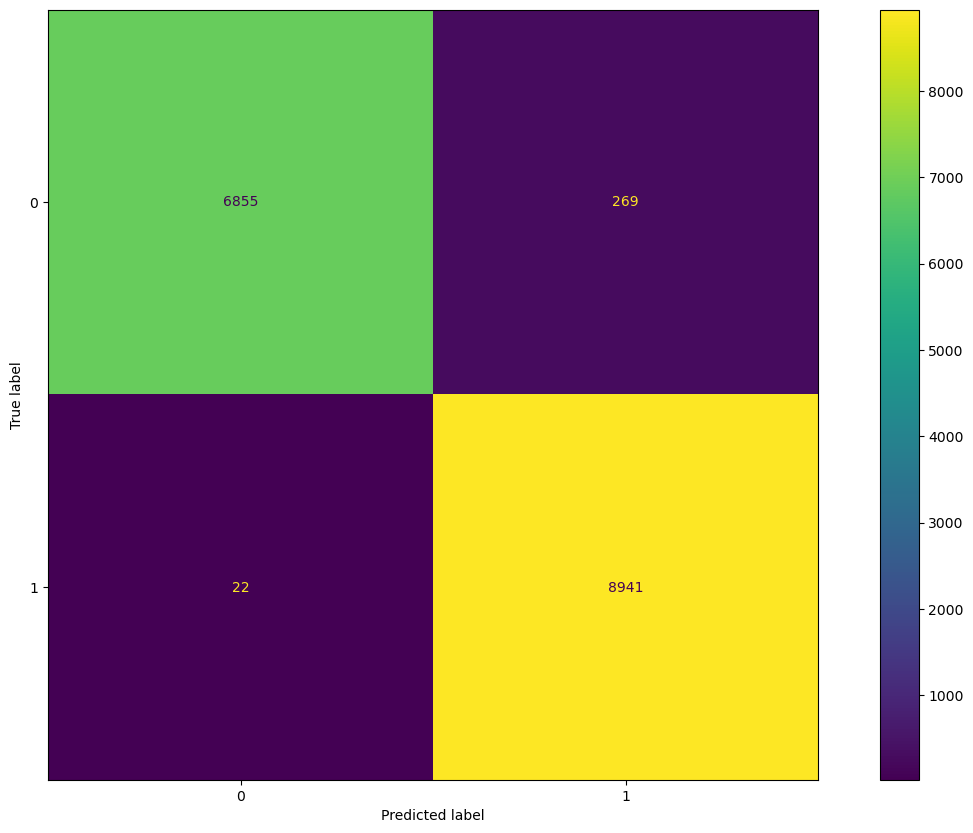

In [44]:
plot_confusion_matrix(y_test, y_pred, model)

In [45]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train Score: {train_score:.2f}")
print(f"Test Score: {test_score:.2f}")

Train Score: 0.98
Test Score: 0.98


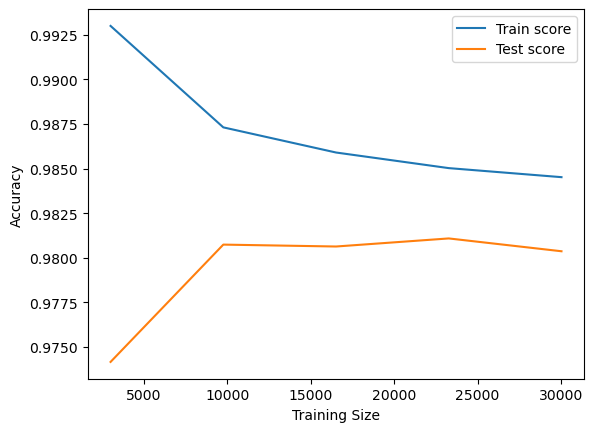

In [47]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    pipeline_model, X_train, y_train, cv=5, scoring='accuracy'
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, test_mean, label="Test score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [48]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Mean CV Score: {cv_scores.mean():.2f}")


Mean CV Score: 0.98


In [51]:
import joblib

joblib.dump(model, 'spam_classifier_model.joblib')

['spam_classifier_model.joblib']